## Step 1: Setup and Imports

In [1]:
!pip install -q transformers datasets evaluate accelerate
!pip install -q scikit-learn

import os
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)
from torchvision.transforms import (
    Compose,
    RandomResizedCrop,
    RandomHorizontalFlip,
    Resize,
    CenterCrop,
    ToTensor,
    Normalize
)
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from tqdm import auto
auto.tqdm = auto.std_tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 12.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 39.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2025-11-02 10:52:59.362425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762080779.560925      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762080779.632463      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Step 2: Data Preprocessing

In [2]:
# 1. Define Path and Load Dataset
# This path points to the 'images' directory, which contains the 101 class subfolders
image_dir = "/kaggle/input/food41/images" 

# Use load_dataset with "imagefolder"
# This automatically loads all images and uses the folder names as labels
print("Loading dataset from image folder...")
full_dataset = load_dataset("imagefolder", data_dir=image_dir)
print("Dataset loaded.")

# 2. Get Class Labels
# The 'datasets' library automatically creates the labels for us
class_names = full_dataset["train"].features["label"].names
label2id = {name: i for i, name in enumerate(class_names)}
id2label = {i: name for i, name in enumerate(class_names)}
print(f"Found {len(class_names)} classes.")

# 3. Create Train/Test Split
# The dataset loads as a single 'train' split. We must split it ourselves.
# We'll use a 75% train / 25% test split, similar to the original Food-101.
print("Splitting dataset...")
split_ds = full_dataset["train"].train_test_split(test_size=0.25, seed=42, stratify_by_column="label")

# Rename to 'raw' - we will create the final 'train_ds' and 'test_ds' below
train_ds_raw = split_ds['train']
test_ds_raw = split_ds['test']

print(f"Original training samples: {len(train_ds_raw)}, Test samples: {len(test_ds_raw)}")

# -----------------------------------------------------------------
# --- THIS IS THE ADJUSTMENT TO USE 50% OF DATA ---
# -----------------------------------------------------------------
PERCENT_TO_USE = 0.5 # Use 50% of the data
SUBSET_TRAIN_SIZE = int(len(train_ds_raw) * PERCENT_TO_USE)
SUBSET_TEST_SIZE = int(len(test_ds_raw) * PERCENT_TO_USE)

# Shuffle and select a 50% subset
train_ds_raw = train_ds_raw.shuffle(seed=42).select(range(SUBSET_TRAIN_SIZE))
test_ds_raw = test_ds_raw.shuffle(seed=42).select(range(SUBSET_TEST_SIZE))

print(f"training samples: {len(train_ds_raw)},  test samples: {len(test_ds_raw)}")
# -----------------------------------------------------------------
# --- END OF ADJUSTMENT ---
# -----------------------------------------------------------------


# 4. Define Augmentation & Preprocessing
model_checkpoint = "google/vit-base-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

# Get normalization stats from the processor
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

# --- Define transforms ---
train_transforms = Compose([
    RandomResizedCrop(image_processor.size["height"]),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

val_transforms = Compose([
    Resize(image_processor.size["height"]),
    CenterCrop(image_processor.size["height"]),
    ToTensor(),
    normalize,
])

# --- Create preprocessing functions ---
def preprocess_train(examples):
    # 'image' is a PIL object here, thanks to load_dataset
    examples['pixel_values'] = [train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def preprocess_val(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# -----------------------------------------------------------------
# --- THIS IS THE UPDATED PART (THE FIX) ---
# -----------------------------------------------------------------
# Apply the transforms using .map() for speed
# This will pre-process all images and show a progress bar.

print("Applying train transforms (this will take a few minutes)...")
train_ds = train_ds_raw.map(
    preprocess_train,
    batched=True,  # Process in batches
    remove_columns=['image'] # Remove the original PIL image to save RAM
)

print("Applying test transforms...")
test_ds = test_ds_raw.map(
    preprocess_val,
    batched=True,  # Process in batches
    remove_columns=['image'] # Remove the original PIL image
)

print("Data preprocessing complete.")
# -----------------------------------------------------------------
# --- END OF UPDATE ---
# -----------------------------------------------------------------

Loading dataset from image folder...


Resolving data files:   0%|          | 0/101000 [00:00<?, ?it/s]

Computing checksums:  78%|#######8  | 79105/101000 [00:05<00:01, 15819.59it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset loaded.
Found 101 classes.
Splitting dataset...
Original training samples: 75750, Test samples: 25250
training samples: 37875,  test samples: 12625


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Applying train transforms (this will take a few minutes)...


Map:   0%|          | 0/37875 [00:00<?, ? examples/s]

Applying test transforms...


Map:   0%|          | 0/12625 [00:00<?, ? examples/s]

Data preprocessing complete.


## Step 3: Fine-Tuning Pipeline

In [3]:
# 1. Load the Model
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(class_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True, # Allows fine-tuning the head
)

# 2. Define Training Arguments
# This uses the tips from your assignment (FP16, 3-5 epochs)
training_args = TrainingArguments(
    output_dir="./vit-base-food101-results",
    num_train_epochs=3,  # As suggested (3-5)
    per_device_train_batch_size=32, # Adjust based on Kaggle GPU RAM
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1, # Use if you hit memory issues
    fp16=True,  # Use FP16 as suggested
    learning_rate=2e-5,
    logging_steps=100,
    eval_strategy="epoch", # Switched from "evaluation_strategy"
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False,
    report_to="none",
)

# 3. Define Metrics Function
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# 4. Data Collator
# This will batch our 'pixel_values' and 'labels' together
data_collator = DefaultDataCollator()

# 5. Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor, # Not a tokenizer, but passes processor config
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# 6. Start Training!
trainer.train()

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_37/3104183069.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.304200,1.005029,0.803406
2,0.748800,0.742052,0.829861
3,0.520400,0.701971,0.834931


TrainOutput(global_step=3552, training_loss=1.1961575086052354, metrics={'train_runtime': 15484.8527, 'train_samples_per_second': 7.338, 'train_steps_per_second': 0.229, 'total_flos': 8.8128400707648e+18, 'train_loss': 1.1961575086052354, 'epoch': 3.0})

## Step 4: Evaluation

In [4]:
eval_results = trainer.evaluate(test_ds)
print(f"Final Test Accuracy: {eval_results['eval_accuracy']:.4f}")

Final Test Accuracy: 0.8349


Generating predictions for confusion matrix...


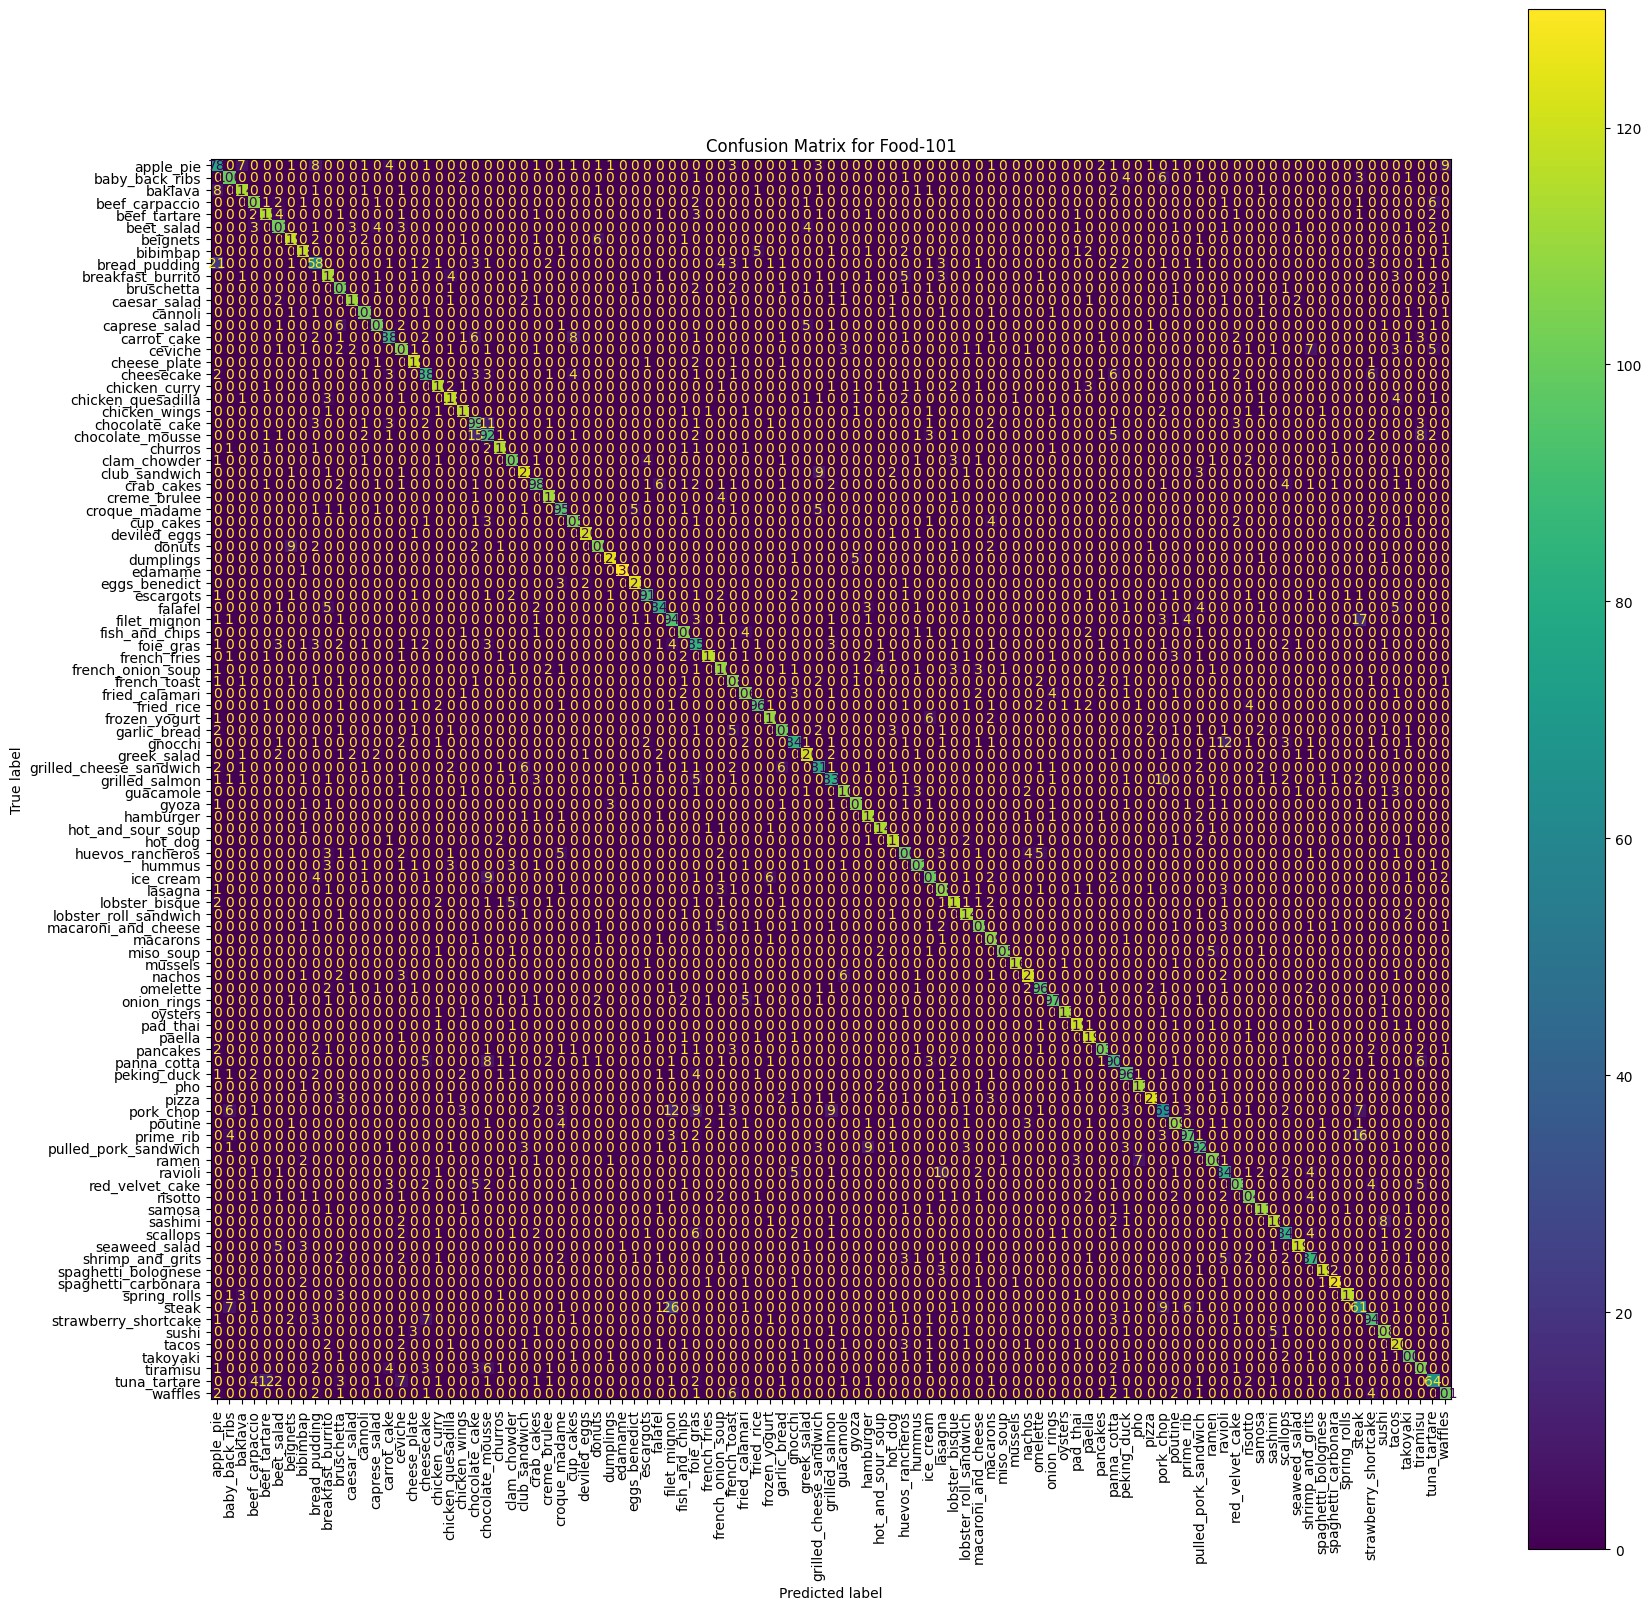

In [5]:
print("Generating predictions for confusion matrix...")
# Get predictions
predictions = trainer.predict(test_ds)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_preds, labels=range(len(class_names)))

# Plot it
# You may need to adjust the figure size for 101 classes
fig, ax = plt.subplots(figsize=(20, 20)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix for Food-101")
plt.show()

Device set to use cuda:0


Creating pipeline...
Pipeline created.
Getting sample image...
True Label: macaroni_and_cheese
Model Predictions:
[{'label': 'macaroni_and_cheese', 'score': 0.9502165913581848}, {'label': 'gnocchi', 'score': 0.009935786947607994}, {'label': 'deviled_eggs', 'score': 0.003188097383826971}, {'label': 'ravioli', 'score': 0.001628320780582726}, {'label': 'eggs_benedict', 'score': 0.0016251435736194253}]


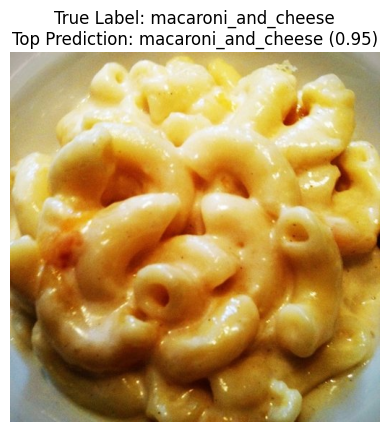

In [8]:
from transformers import pipeline
from PIL import Image as PILImage

# --- FIX 1: Add the 'image_processor' to the pipeline ---
# The pipeline needs to know how to resize and normalize the image.
print("Creating pipeline...")
pipe = pipeline(
    "image-classification", 
    model=trainer.model, 
    image_processor=image_processor,  # <-- This is the main fix
    device=trainer.model.device
)
print("Pipeline created.")

# --- FIX 2: Use 'test_ds_raw' to get the sample image ---
# 'test_ds' no longer has the 'image' column, but 'test_ds_raw' does.
print("Getting sample image...")
sample_image_pil = test_ds_raw[0]['image'] # Get the PIL image directly
true_label_id = test_ds_raw[0]['label']
true_label_name = id2label[true_label_id]

print(f"True Label: {true_label_name}")

# Make prediction
print("Model Predictions:")
preds = pipe(sample_image_pil)
print(preds)

# Display the image
plt.imshow(sample_image_pil)
plt.title(f"True Label: {true_label_name}\nTop Prediction: {preds[0]['label']} ({preds[0]['score']:.2f})")
plt.axis('off')
plt.show()

In [9]:
# This zips your checkpoint folder into a new file called "checkpoints.zip"
!zip -r vit-base-food101-results.zip /kaggle/working/vit-base-food101-results

  adding: kaggle/working/vit-base-food101-results/ (stored 0%)
  adding: kaggle/working/vit-base-food101-results/checkpoint-1184/ (stored 0%)
  adding: kaggle/working/vit-base-food101-results/checkpoint-1184/training_args.bin (deflated 52%)
  adding: kaggle/working/vit-base-food101-results/checkpoint-1184/rng_state.pth (deflated 25%)
  adding: kaggle/working/vit-base-food101-results/checkpoint-1184/scheduler.pt (deflated 55%)
  adding: kaggle/working/vit-base-food101-results/checkpoint-1184/preprocessor_config.json (deflated 47%)
  adding: kaggle/working/vit-base-food101-results/checkpoint-1184/model.safetensors (deflated 7%)
  adding: kaggle/working/vit-base-food101-results/checkpoint-1184/trainer_state.json (deflated 69%)
  adding: kaggle/working/vit-base-food101-results/checkpoint-1184/scaler.pt (deflated 60%)
  adding: kaggle/working/vit-base-food101-results/checkpoint-1184/config.json (deflated 66%)
  adding: kaggle/working/vit-base-food101-results/checkpoint-1184/optimizer.pt (de